## Setting up some example data

(-11.394921214304677,
 21.49499624830022,
 -11.264066235483519,
 21.48876505883255)

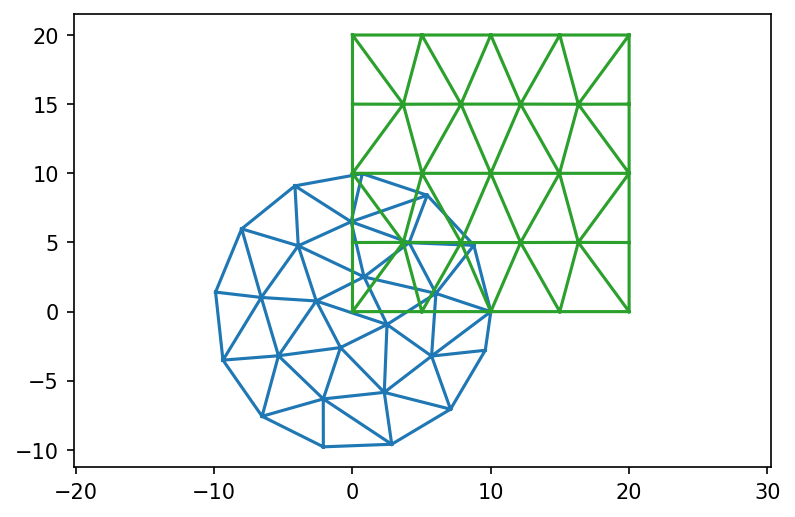

In [1]:
import numpy as np
import dmsh

import meshing, polygons # Our libraries

# Plotting tools
import matplotlib.pyplot as plt
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
%matplotlib inline
plt.rcParams['figure.figsize'] = (6,4)
plt.rcParams['figure.dpi'] = 150

p0 = [10.0, 0., 0.]             # circle := [radius, centerx, centery]
p1 = [20.0, 20.0, 10., 10., 0]  # rectangle := [width, height, centerx, centery, rotation (radians)]

def get_few_proxy_points(proxy):
    if len(proxy) == 3:
        r = proxy[0]
        cx = proxy[1]
        cy = proxy[2]
        circumference = 2 * np.pi
        th = np.array([[t for t in np.arange(0, circumference, 0.5)]])
        th = th.T
        pcircle = np.array([cx, cy]) + r * np.hstack((np.cos(th), np.sin(th)))
        return pcircle
    else:
        sx = proxy[0]
        sy = proxy[1]
        cx = proxy[2]
        cy = proxy[3]
        theta = proxy[4]
        pbox = np.array([[-0.5, -0.5], [-0.5,0.5], [0.5, 0.5], [0.5, -0.5], [-0.5,-0.5]])
        S = np.diag([sx, sy])
        R = np.array([[np.cos(theta), -np.sin(theta)],
                      [np.sin(theta), np.cos(theta)]])
        pbox = np.dot(np.dot(pbox, S), R) + np.array([cx, cy])
        return pbox

ps0 = get_few_proxy_points(p0)
ps1 = get_few_proxy_points(p1)[:-1]

vs0, fs0 = dmsh.generate(dmsh.Polygon(ps0), 5.0)
vs1, fs1 = dmsh.generate(dmsh.Polygon(ps1), 5.0)

# Plot triangles
plt.triplot(vs0[:, 0], vs0[:, 1], fs0)
plt.triplot(vs1[:, 0], vs1[:, 1], fs1)

plt.axis("equal")

## Computing mesh-mesh intersections

Brute force time: 0.16857647895812988 s
AABBs time: 0.05086398124694824 s


(-11.394921214304677,
 21.49499624830022,
 -11.264066235483519,
 21.48876505883255)

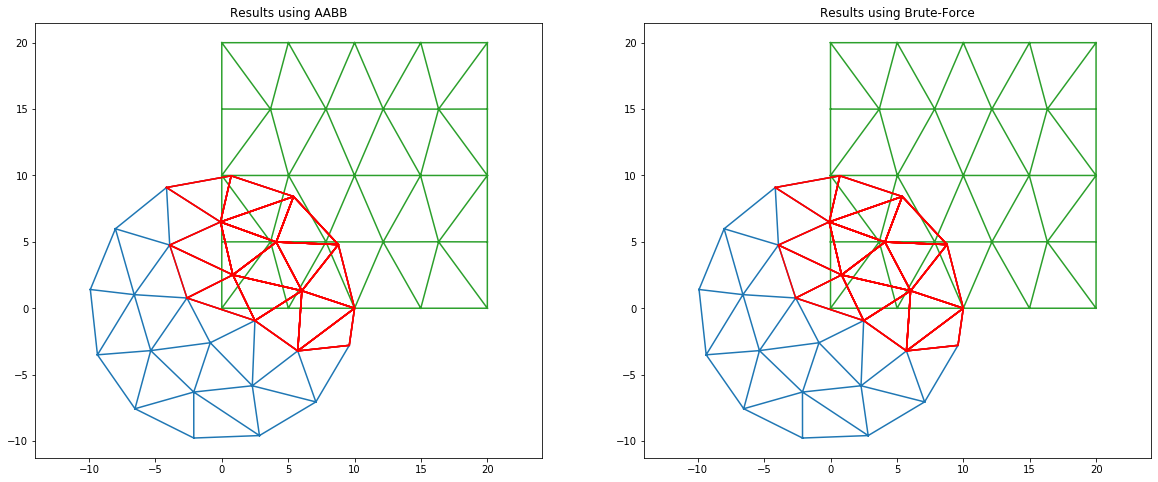

In [2]:
# Make the triangles 3-dimensional
plt.rcParams['figure.figsize'] = (20,8)
vs0_new = np.zeros((vs0.shape[0], 3))
vs0_new[:, :-1] = vs0
vs1_new = np.zeros((vs1.shape[0], 3))
vs1_new[:, :-1] = vs1

import time
now = time.time()
intersections_BF = meshing.mesh_mesh_intersection_brute_force(vs0_new, vs1_new, fs0, fs1)
end = time.time()
print("Brute force time:", end - now, "s")
now = time.time()
intersections_AABB = meshing.mesh_mesh_intersection_aabbs(vs0_new, vs1_new, fs0, fs1)
end = time.time()
print("AABBs time:", end - now, "s")


plt.subplot(1, 2, 1)
plt.triplot(vs0[:, 0], vs0[:, 1], fs0)
plt.triplot(vs1[:, 0], vs1[:, 1], fs1)
for inter in intersections_AABB:
    coords = np.zeros((4, 2))
    t0 = inter[0]
    t1 = inter[1]
    xs0 = [x[0] for x in t0]
    xs0.append(xs0[0])
    ys0 = [x[1] for x in t0]
    ys0.append(ys0[0])
    plt.plot(xs0, ys0, 'r')
plt.title('Results using AABB')
plt.axis("equal")

plt.subplot(1, 2, 2)
plt.triplot(vs0[:, 0], vs0[:, 1], fs0)
plt.triplot(vs1[:, 0], vs1[:, 1], fs1)
for inter in intersections_BF:
    coords = np.zeros((4, 2))
    t0 = inter[0]
    t1 = inter[1]
    xs0 = [x[0] for x in t0]
    xs0.append(xs0[0])
    ys0 = [x[1] for x in t0]
    ys0.append(ys0[0])
    plt.plot(xs0, ys0, 'r')
    
plt.title('Results using Brute-Force')
plt.axis("equal")


## Finding overlapping area

Area of overlap = 75.39654109154999 Analytical overlap (for a perfect circle) = 78.53981633974483


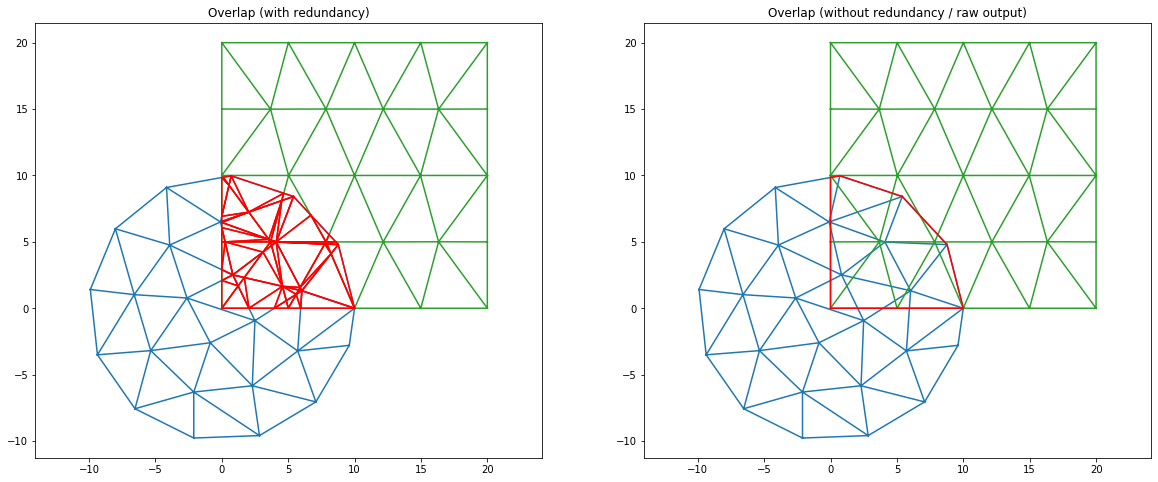

In [3]:
from scipy.spatial import Delaunay
plt.rcParams['figure.figsize'] = (20,8)

overlap_polygon = np.empty((0, 3, 2))

for intersection in intersections_AABB:
    tri0 = [p for p in intersection[0]]
    tri1 = [p for p in intersection[1]]
    # Find the points of the overlapping polygon
    polygonpoints = polygons.sutherland_hodgman_clipping_tri(tri0, tri1)
    polygonpoints = np.unique(np.append(polygonpoints,
                                        polygons.sutherland_hodgman_clipping_tri(tri1, tri0),
                                        axis=0).round(decimals=5), axis=0)
    # Order the points in clockwise order (if the intersection is not only in one point)
    if polygonpoints.shape[0] > 2:
        polygonpoints = polygons.jarvis_march(polygonpoints[:, :-1]) # This needs two-dimensional input
        # Compute the triangles of the polygon
        polygon = Delaunay(polygonpoints)
        for tri in polygon.simplices:
            overlap_polygon = np.append(overlap_polygon, [[polygonpoints[tri[0]],
                                                           polygonpoints[tri[1]],
                                                           polygonpoints[tri[2]]]], axis=0)

# Plotting the raw overlap
plt.subplot(1, 2, 1)
polygonpoints = np.empty((0, 2))
plt.triplot(vs0[:, 0], vs0[:, 1], fs0)
plt.triplot(vs1[:, 0], vs1[:, 1], fs1)
for t in overlap_polygon:
    xs = [x[0] for x in t]
    xs.append(xs[0])
    ys = [x[1] for x in t]
    ys.append(ys[0])
    plt.plot(xs, ys, 'r')
    for p in list(zip(xs, ys)):
        polygonpoints = np.append(polygonpoints, [p], axis=0)
plt.axis("equal")
plt.title("Overlap (with redundancy)")

# Finding the area of the overlap (i.e. no redundant points)
polygonpoints = np.empty((0, 3))
for intersection in intersections_AABB:
    tri0 = [p for p in intersection[0]]
    tri1 = [p for p in intersection[1]]
    # Find the points of the overlapping polygon
    newpolygonpoints = polygons.sutherland_hodgman_clipping_tri(tri0, tri1)
    newpolygonpoints = np.unique(np.append(newpolygonpoints,
                                           polygons.sutherland_hodgman_clipping_tri(tri1, tri0),
                                           axis=0).round(decimals=5), axis=0)
    if newpolygonpoints.shape[0] > 2:
        polygonpoints = np.append(polygonpoints, newpolygonpoints, axis=0)
polygonpoints = polygons.jarvis_march(polygonpoints[:, :-1])

plt.subplot(1, 2, 2)
plt.triplot(vs0[:, 0], vs0[:, 1], fs0)
plt.triplot(vs1[:, 0], vs1[:, 1], fs1)
plt.plot([p[0] for p in polygonpoints], [p[1] for p in polygonpoints], 'r')
plt.axis("equal")
plt.title("Overlap (without redundancy / raw output)")

A = polygons.compute_polygon_area(polygonpoints)
print("Area of overlap =", A, "Analytical overlap (for a perfect circle) =", np.pi * p0[0]**2 / 4)

## Or more simply

In [5]:
now = time.time()
A = polygons.compute_polygon_area(meshing.compute_intersection_polygon(vs0_new, vs1_new, fs0, fs1))
end = time.time()
print("Area of overlap =", A, "computed in ", end - now, "s")

Area of overlap = 75.39654109154999 computed in  0.18499302864074707 s


## Triangulation Update of a proxy

(-21.97285513050157,
 25.83325923633705,
 -21.711145172859258,
 25.820796857401703)

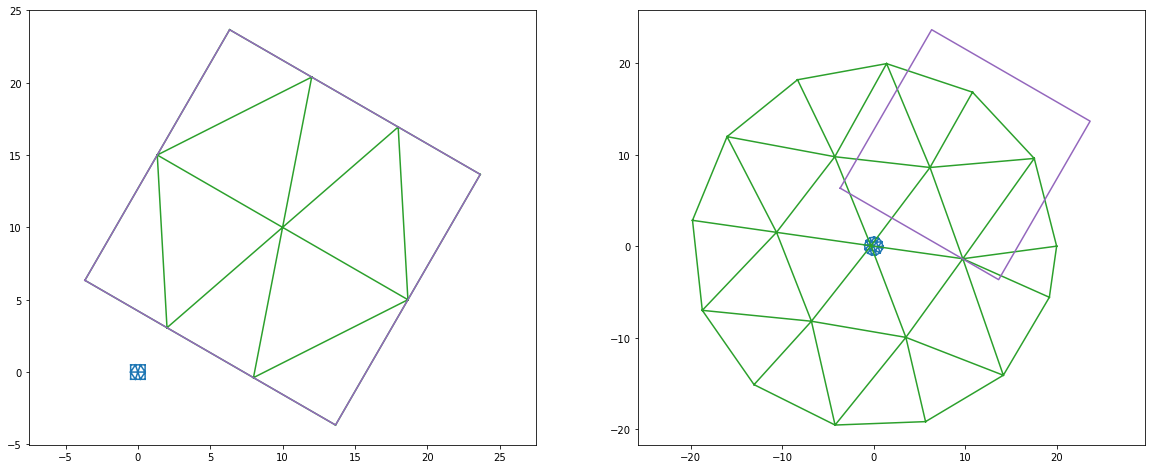

In [8]:
'''
Assumes that the mesh is centered at (0, 0) and has unit size
'''
def update_proxy_mesh(proxy, vs, fs):
    if len(proxy) == 3:
        r = proxy[0]
        cx = proxy[1]
        cy = proxy[2]
        
        return vs * r + np.array([cx, cy]), fs
    else:
        sx = proxy[0]
        sy = proxy[1]
        cx = proxy[2]
        cy = proxy[3]
        theta = proxy[4]
        S = np.diag([sx, sy])
        R = np.array([[np.cos(theta), -np.sin(theta)],
                      [np.sin(theta), np.cos(theta)]])
        
        return np.dot(np.dot(vs, S), R) + np.array([cx, cy]), fs

    
# Rectangle tests
plt.subplot(1, 2, 1)
punit = [1.0, 1.0, 0., 0., 0]  # rectangle := [width, height, centerx, centery, rotation (radians)]
psunit = polygons.get_minimal_proxy_points(punit)
vsunit, fsunit = dmsh.generate(dmsh.Polygon(psunit), 0.5)

# The unit mesh
plt.triplot(vsunit[:, 0], vsunit[:, 1], fsunit)

vsupdated, fsupdated = update_proxy_mesh([20, 20, 10, 10, np.pi / 6], vsunit, fsunit)
plt.triplot(vsupdated[:, 0], vsupdated[:, 1], fsupdated)
ppoints = get_few_proxy_points([20, 20, 10, 10, np.pi / 6])
plt.plot(ppoints[:, 0], ppoints[:,1 ])

plt.axis("equal")

# Circle  tests
plt.subplot(1, 2, 2)
punit = [1.0, 0, 0.]
psunit = polygons.get_minimal_proxy_points(punit)
vsunit, fsunit = dmsh.generate(dmsh.Polygon(psunit), .75)

# The unit mesh
plt.triplot(vsunit[:, 0], vsunit[:, 1], fsunit)

vsupdated, fsupdated = update_proxy_mesh([20, 0, 0], vsunit, fsunit)
plt.triplot(vsupdated[:, 0], vsupdated[:, 1], fsupdated)
ppoints = get_few_proxy_points([20, 20, 10, 10, np.pi / 6])
plt.plot(ppoints[:, 0], ppoints[:,1 ])

plt.axis("equal")